In [1]:
#Check the current working directory
import os
print(os.getcwd())

/DATA05/home/jiwoolim24/test


In [2]:
#scanpy tutorial day 1

#load required libraries
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors #pip install scikit-learn
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from kneed import KneeLocator as kl #pip install kneed

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [3]:
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')


In [4]:
#set up directory
large_root = "/DATA05/home/jiwoolim24/test/scRNAseq_Workshop"
results_file = large_root + "\pbmc3k.h5ad"

In [5]:
#load data
print("Reading data...")
adata = sc.read_10x_mtx(large_root, var_names = 'gene_symbols',
                        cache=True)

Reading data...
... reading from cache file cache/DATA05-home-jiwoolim24-test-scRNAseq_Workshop-matrix.h5ad


In [6]:
#print data
adata
# obs = cells  vars = genes
#2700 cells and 32738 genes. Data are 3000 peripheral blood mononuclear cells (immune cell types)

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [86]:
adata.obs

n_genes_by_counts  total_counts  total_counts_mt  \
AAACATACAACCAC-1                781        2421.0             73.0   
AAACATTGAGCTAC-1               1352        4903.0            186.0   
AAACATTGATCAGC-1               1131        3149.0             28.0   
AAACCGTGCTTCCG-1                960        2639.0             46.0   
AAACCGTGTATGCG-1                522         981.0             12.0   
...                             ...           ...              ...   
TTTCGAACTCTCAT-1               1155        3461.0             73.0   
TTTCTACTGAGGCA-1               1227        3447.0             32.0   
TTTCTACTTCCTCG-1                622        1684.0             37.0   
TTTGCATGAGAGGC-1                454        1024.0             21.0   
TTTGCATGCCTCAC-1                724        1985.0             16.0   

                  pct_counts_mt  
AAACATACAACCAC-1       3.015283  
AAACATTGAGCTAC-1       3.793596  
AAACATTGATCAGC-1       0.889171  
AAACCGTGCTTCCG-1       1.743085  
AAACCGTGTATGCG-1       1.223242  
...                         ...  
TTTCGAACTCTCAT-1       2.109217  
TTTCTACTGAGGCA-1       0.928343  
TTTCTACTTCCTCG-1       2.197150  
TTTGCATGAGAGGC-1       2.050781  
TTTGCATGCCTCAC-1       0.806045  

[2700 rows x 4 columns]

In [87]:
adata.var

gene_ids     mt  n_cells_by_counts  mean_counts  \
MIR1302-10    ENSG00000243485  False                  0          0.0   
FAM138A       ENSG00000237613  False                  0          0.0   
OR4F5         ENSG00000186092  False                  0          0.0   
RP11-34P13.7  ENSG00000238009  False                  0          0.0   
RP11-34P13.8  ENSG00000239945  False                  0          0.0   
...                       ...    ...                ...          ...   
AC145205.1    ENSG00000215635  False                  0          0.0   
BAGE5         ENSG00000268590  False                  0          0.0   
CU459201.1    ENSG00000251180  False                  0          0.0   
AC002321.2    ENSG00000215616  False                  0          0.0   
AC002321.1    ENSG00000215611  False                  0          0.0   

              pct_dropout_by_counts  total_counts  
MIR1302-10                    100.0           0.0  
FAM138A                       100.0           0.0  
OR4F5                         100.0           0.0  
RP11-34P13.7                  100.0           0.0  
RP11-34P13.8                  100.0           0.0  
...                             ...           ...  
AC145205.1                    100.0           0.0  
BAGE5                         100.0           0.0  
CU459201.1                    100.0           0.0  
AC002321.2                    100.0           0.0  
AC002321.1                    100.0           0.0  

[32738 rows x 6 columns]

In [7]:
# annotate mitochondrial genes as 'mt' and calculate qc metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

#copy command
QC_data = adata.copy()

In [8]:
#basic filtering
sc.pp.filter_cells(QC_data, min_genes=200)
sc.pp.filter_genes(QC_data, min_cells=3) 
# gene 하나가 3cells에만 나오면 cross out.

filtered out 19024 genes that are detected in less than 3 cells


In [9]:
# actually do the filtering by slicing the AnnData object

# to exclude doublets
QC_data = QC_data[QC_data.obs.n_genes_by_counts < 2200, :]
# to exclude low quality cells (e.g. mt genes)
QC_data = QC_data[QC_data.obs.pct_counts_mt < 5, :]

In [10]:
norm_data = QC_data.copy()
# normalize counts to 10,000 reads per cell..
sc.pp.normalize_total(norm_data, target_sum=1e4)


normalizing counts per cell
    finished (0:00:00)


In [11]:
#log n+1 transform
sc.pp.log1p(norm_data)

In [12]:
# identify highly variable genes
sc.pp.highly_variable_genes(norm_data, min_mean=0.0125, max_mean=3, min_disp=0.5)
#min_mean = exclude those genes that are super variable by having means that are very close to zero

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


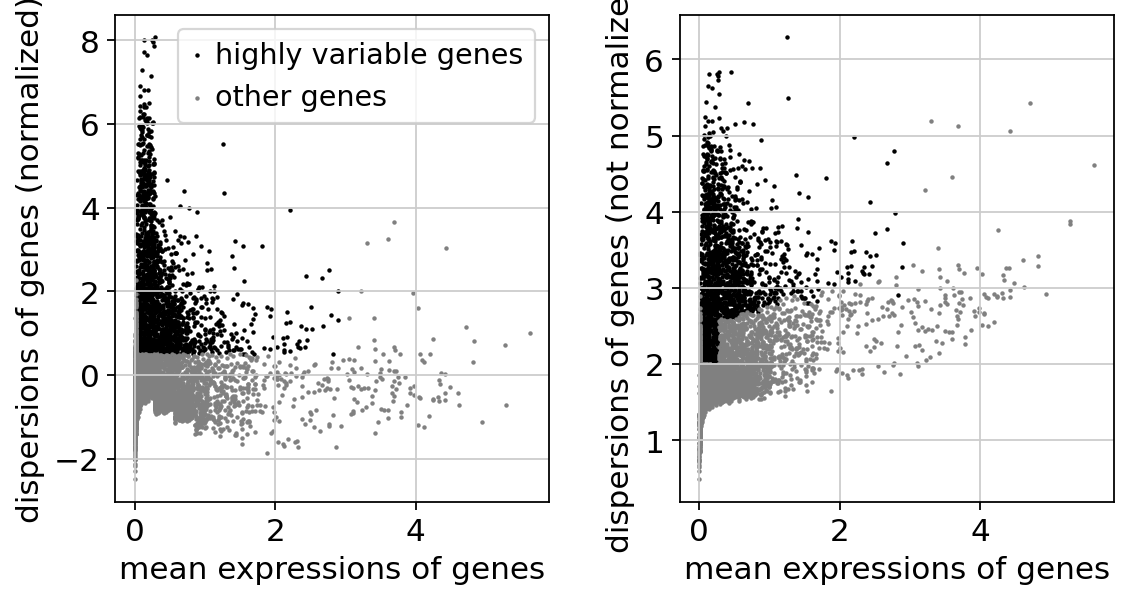

In [13]:
#plot dispersion vs expression
sc.pl.highly_variable_genes(norm_data)

In [14]:
HVG_data = norm_data.copy()
#filter to only include HVGs
HVG_data.raw = HVG_data # freeze state of HVG_data by saving as raw attribute
HVG_data = HVG_data[:, HVG_data.var.highly_variable]


In [15]:
pcHVG_data = HVG_data.copy()
#scale to unit variance for PCA, clip values exceding var 10
sc.pp.scale(pcHVG_data, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


computing PCA
    with n_comps=50
    finished (0:00:00)


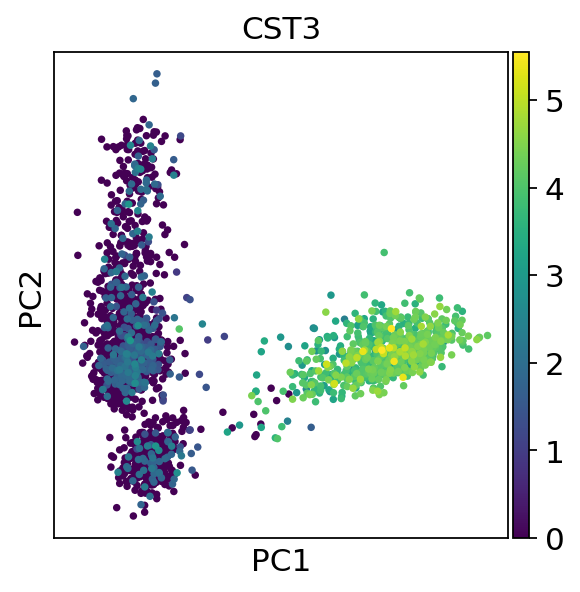

In [16]:
# reduce the dimensionality of the data using PCA
sc.tl.pca(pcHVG_data, svd_solver='arpack')

#save the result
pcHVG_data.write(results_file)
#print
pcHVG_data

#scatter in the PCA coordinates of HVGs, won't be used later on, only for vis
sc.pl.pca(pcHVG_data, color='CST3')

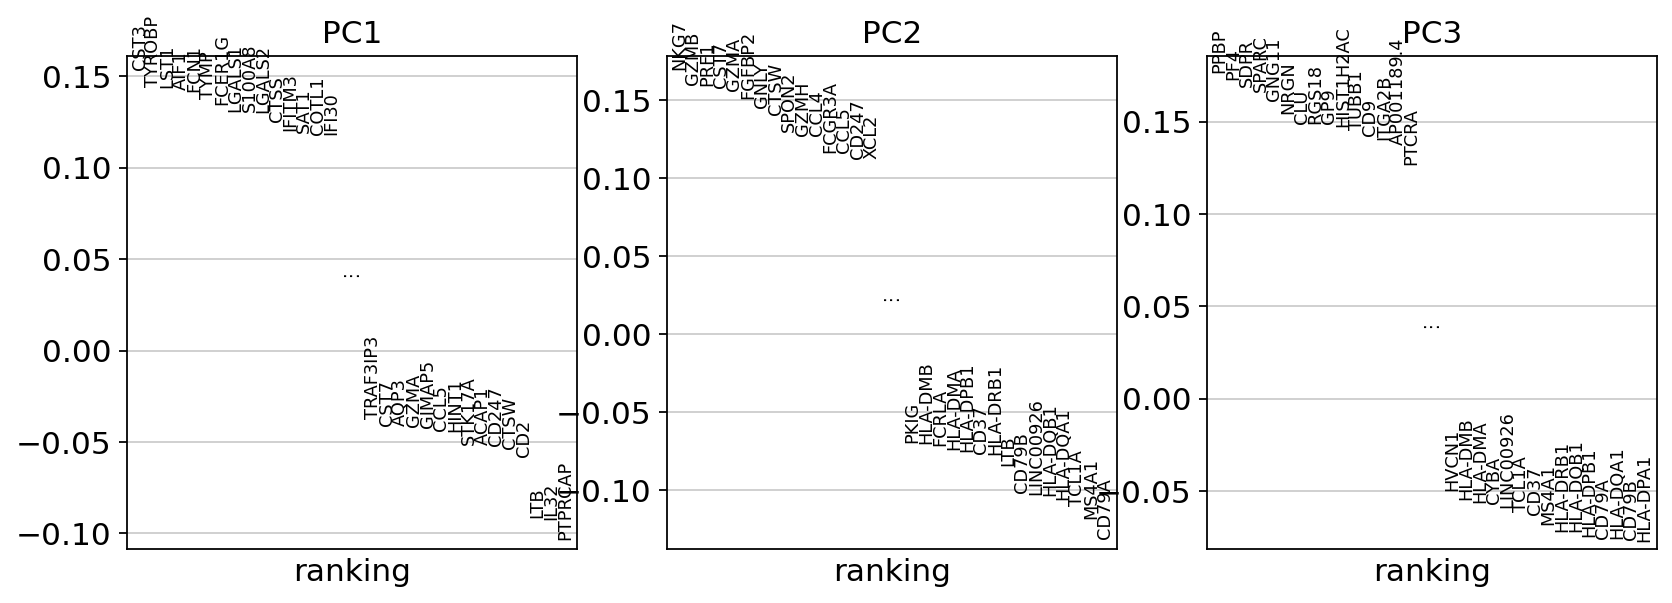

In [18]:
#plot the loadings, or the contribution of each gene to the PCs
sc.pl.pca_loadings(pcHVG_data)

computing PCA
    with n_comps=50
    finished (0:00:00)


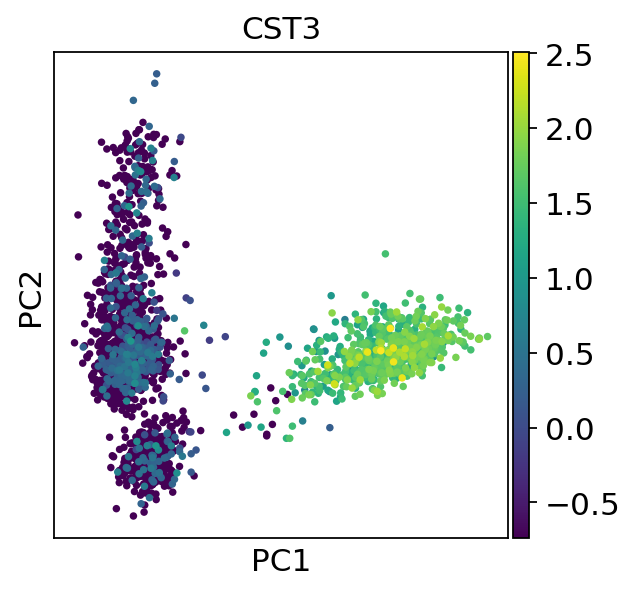

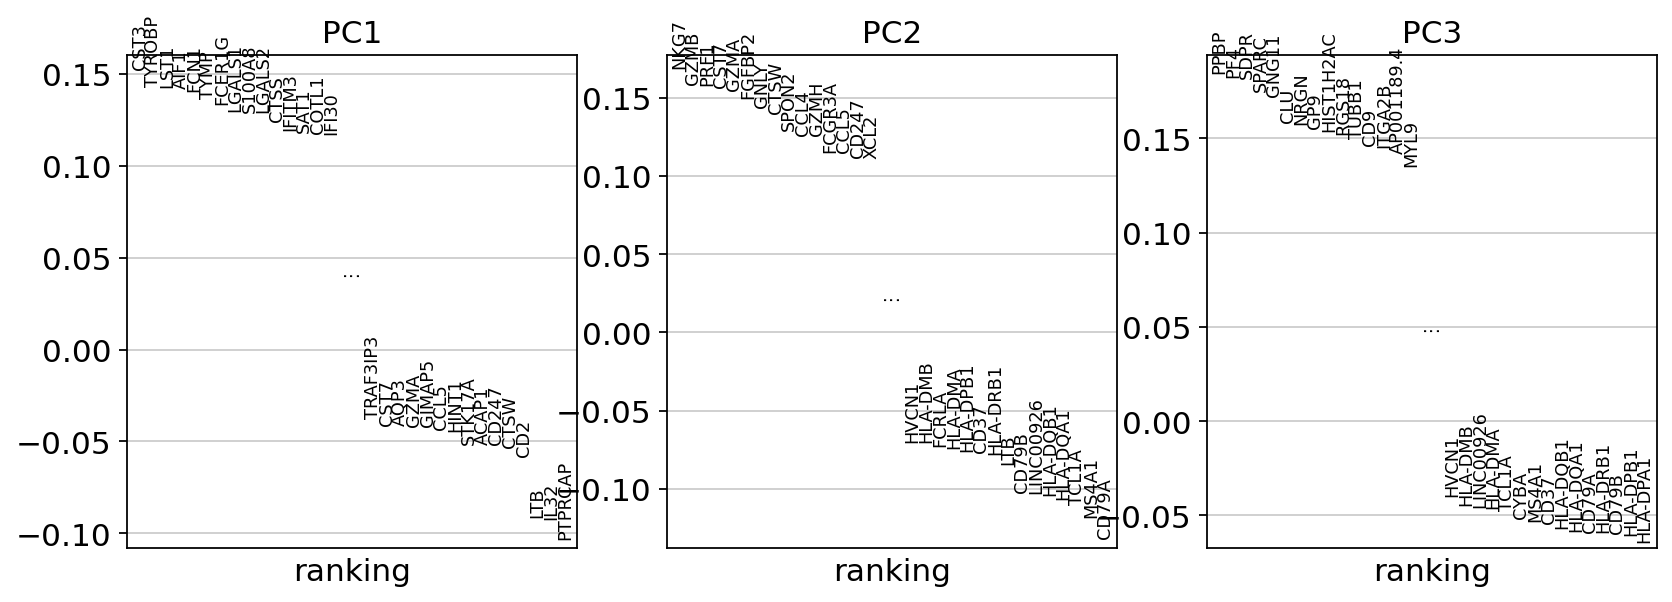

In [23]:
#scatter in the PCA coordinates of all genes
sc.pp.scale(norm_data, max_value=10)
sc.tl.pca(norm_data, svd_solver='arpack')
sc.pl.pca(norm_data, color='CST3')
sc.pl.pca_loadings(norm_data)
#To see if this is vastly different than the PCA of only the HVGs.
# good sign that PCA of all genes (raw data) and HVGs are not vasly different. They are not also identical meaning the code is working.

In [25]:
#image you have two samples, and you want to check how similar the PCs are
#how can we quantify the similarity of gene contributions to PCs?


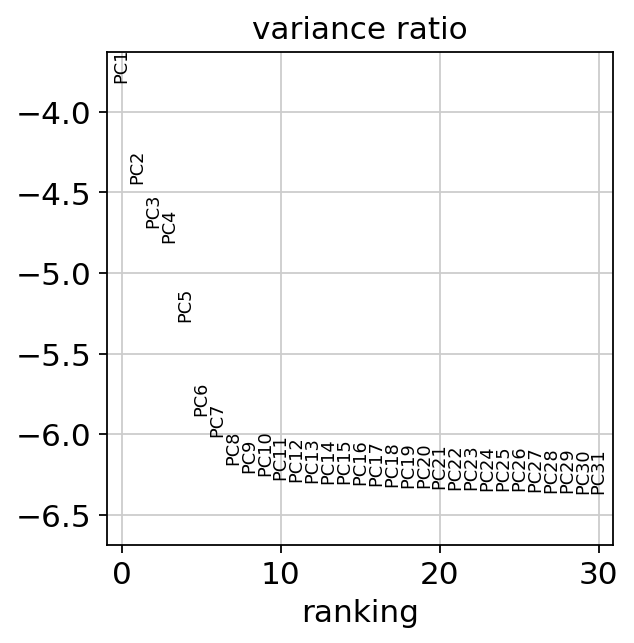

In [27]:
#how many PCs should we use to cluster?
# visualize scree plot
# PC1 explains the most variance
sc.pl.pca_variance_ratio(pcHVG_data, log=True)

#define new function that finds the elbow dimension of the scree plot
def PCA_Elbow_fit(data):
    model = PCA().fit(data)
    explained_variance = model.explained_variance_ratio_
    pcs = list(range(1,explained_variance.shape[0]+1))#enumerate(explained_variance,1)
    klm = kl(pcs, explained_variance, S=1.0, curve='convex', direction='decreasing')
    pcs_used = klm.knee
    pc_list = list(range(1,pcs_used+1))
    new_data = PCA(n_components= pcs_used,svd_solver= "arpack").fit_transform(data)
    return pcs_used, new_data, pcs, explained_variance,pc_list

In [29]:
#extract cell x gene data from scanpy annData and create new pandas dataframe
label = "HVG_data"
new_frame = pd.DataFrame(HVG_data.X.toarray(), index=HVG_data.obs_names, columns=HVG_data.var_names)
pandas_data=new_frame.values
#new_frame.to_csv(output_path)

#execute PCA elbow fitting function
dim,new_matrix,pc_ax,pc_ay,col_labels=PCA_Elbow_fit(pandas_data)
print(dim)

14


In [31]:
#create new data frame of cells x PC values
columns=["PC_"+str(i) for i in col_labels]
output_path = large_root+ "_PCA_"+ label + str(dim)+ ".csv"
PC_frame= pd.DataFrame(new_matrix, index= new_frame.index.values.tolist(), columns = columns)
print(PC_frame.head())
print(PC_frame.shape)
#2637 cells with 14 columns

                       PC_1      PC_2      PC_3      PC_4      PC_5      PC_6  \
AAACATACAACCAC-1  -4.430907  0.262373 -1.492732 -0.000803  1.078565 -0.375005   
AAACATTGAGCTAC-1  -0.755946 -4.268144  6.053718 -1.799756  1.351320 -0.325757   
AAACATTGATCAGC-1  -2.829488  1.411129 -2.966493 -3.689736  0.793966  0.845259   
AAACCGTGCTTCCG-1  11.279478  0.626295  1.217367 -0.591569  0.853547  0.988304   
AAACCGTGTATGCG-1  -2.076111  7.286490  4.471403  5.061394 -3.542382  2.395840   

                      PC_7      PC_8      PC_9     PC_10     PC_11     PC_12  \
AAACATACAACCAC-1 -1.079318 -0.939440  3.131511  1.103112 -1.175607  0.598464   
AAACATTGAGCTAC-1  0.382622  0.423999  1.114896 -1.492343 -0.674534 -1.428759   
AAACATTGATCAGC-1  1.916347  0.943600 -1.158307 -1.200856  0.580037  0.251154   
AAACCGTGCTTCCG-1 -0.645887 -0.354310 -0.949229  0.301238 -0.234260  0.248363   
AAACCGTGTATGCG-1  0.718475 -0.703595 -2.091892  1.734321  1.409950  0.914373   

                     PC_13     P

<IPython.core.display.Javascript object>

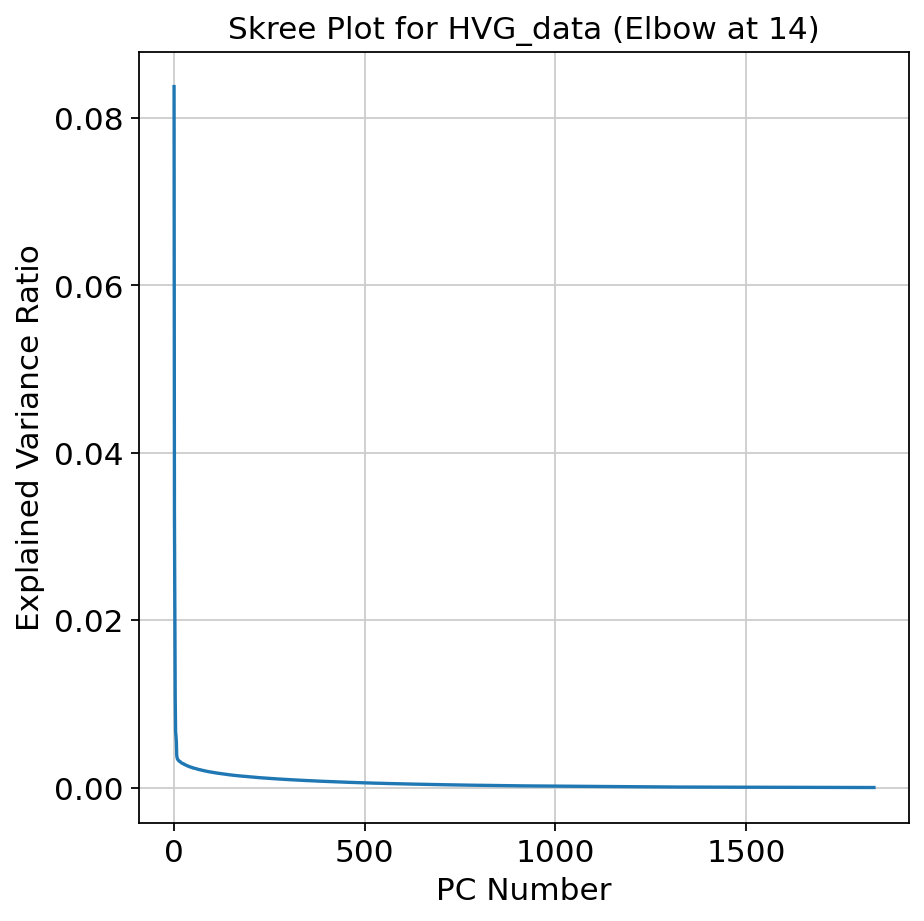

In [81]:
#PC_frame.to_csv(output_path)

fig= plt.figure(figsize = (6,6))
ax1 = fig.add_subplot(111)
ax1.set_title("Skree Plot for "+label+" (Elbow at "+str(dim)+")")
ax1.plot(pc_ax, pc_ay)
ax1.set_xlabel("PC Number")
ax1.set_ylabel("Explained Variance Ratio")
fig.tight_layout()
#plt.savefig(large_root+"/_PCA_"+str(dim)+".png")
#fig.clear()


In [48]:
#back to scanpy
#computing the neighborhood graph
sc.pp.neighbors(pcHVG_data, n_neighbors=10, n_pcs=dim)


computing neighbors
    using 'X_pca' with n_pcs = 14
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [49]:
#visualizing data with umap
sc.tl.umap(pcHVG_data)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


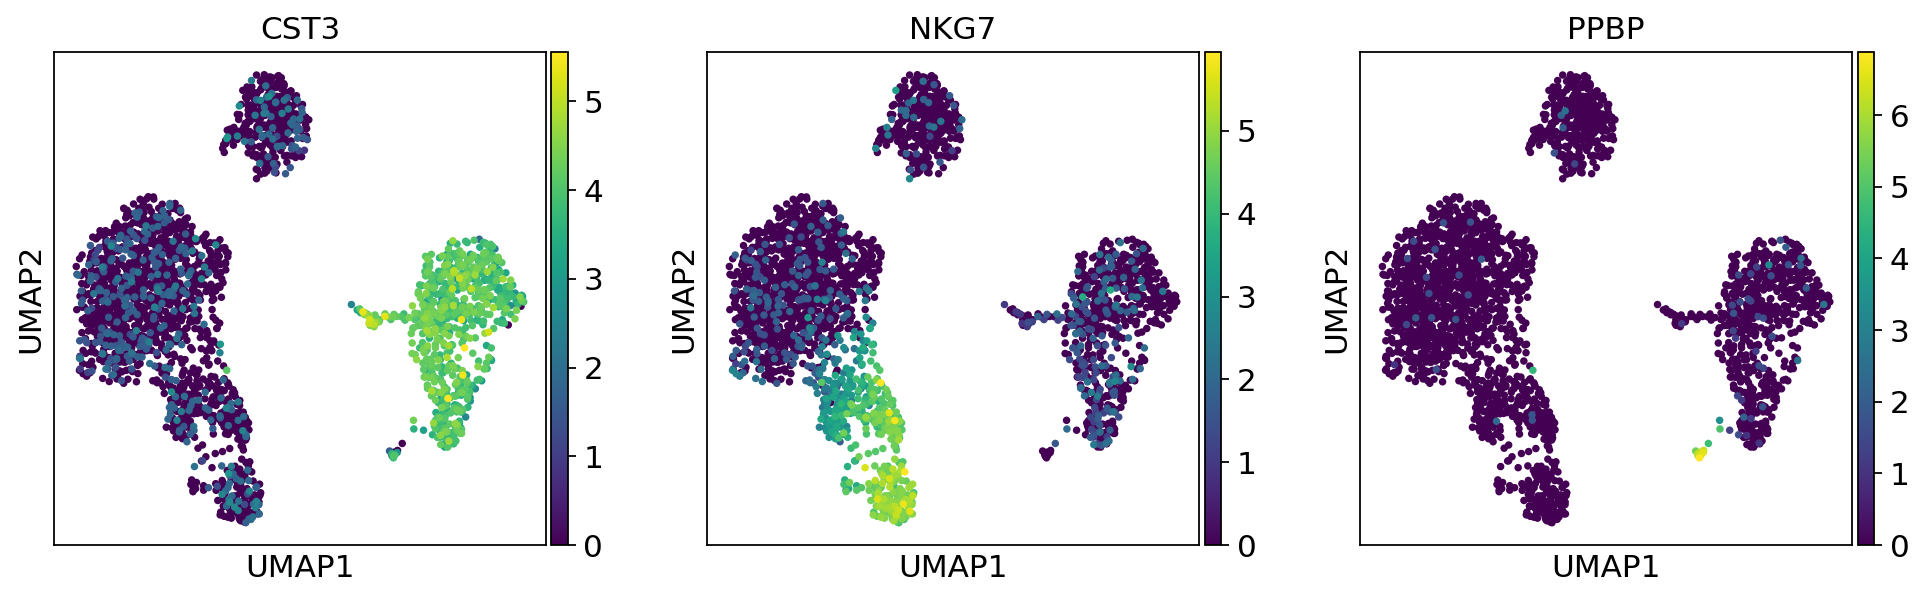

In [50]:
#visualize marker gene expression
sc.pl.umap(pcHVG_data, color=['CST3', 'NKG7', 'PPBP'])

computing tSNE
    using 'X_pca' with n_pcs = 14
    using sklearn.manifold.TSNE


/usr/local/lib64/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:03)


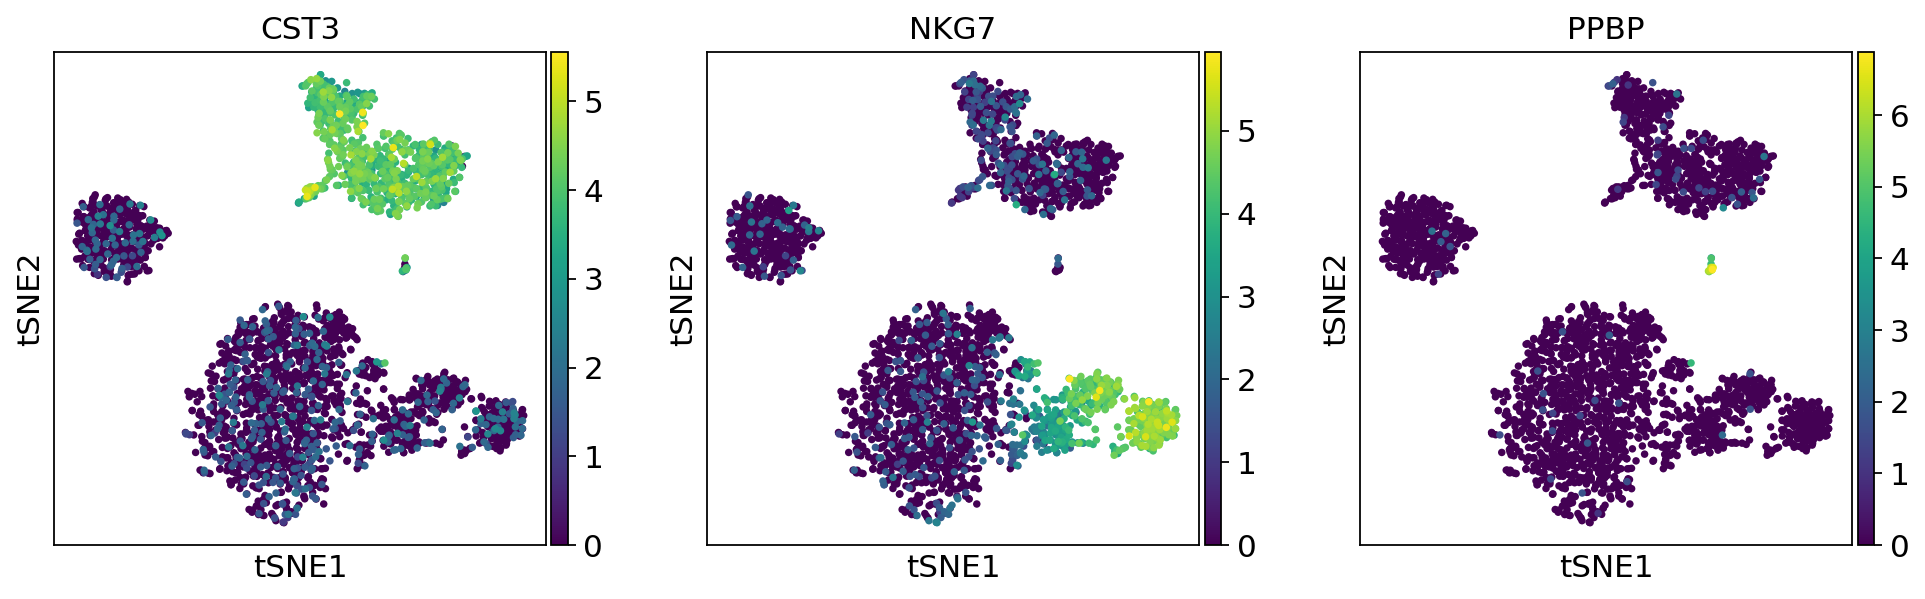

In [51]:

#visualize data with t-SNE
sc.tl.tsne(pcHVG_data, n_pcs = dim)
sc.pl.tsne(pcHVG_data, color=['CST3', 'NKG7', 'PPBP'])

# read raw cell by count matrix in pandas
# what is the fraction of non-zero entries in the matrix?


In [61]:

# we created the following annData objects:
# adata - raw cell by gene count matrix
# QC_data - QC thresholds applied to remove low quality cells and sparsely expressed genes
# norm_data - CPM normalized and log+1 transformed data
# HVG_data - highly variable genes only, cell by CPM & log+1 transformed gene counts
# pcHVG_data - HVG_data with dimensions reduced using PCA


# how many genes were removed by the QC filters? how many cells were removed?
# 63 genes, 19204 cells


# how many different mitochondrial genes were observed?
# 13 genes


# is the PC elbow dimension the same for HVGs and raw data? what about differently filtered or transformed data?



# how will the umap change if we use non-reduced data?


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


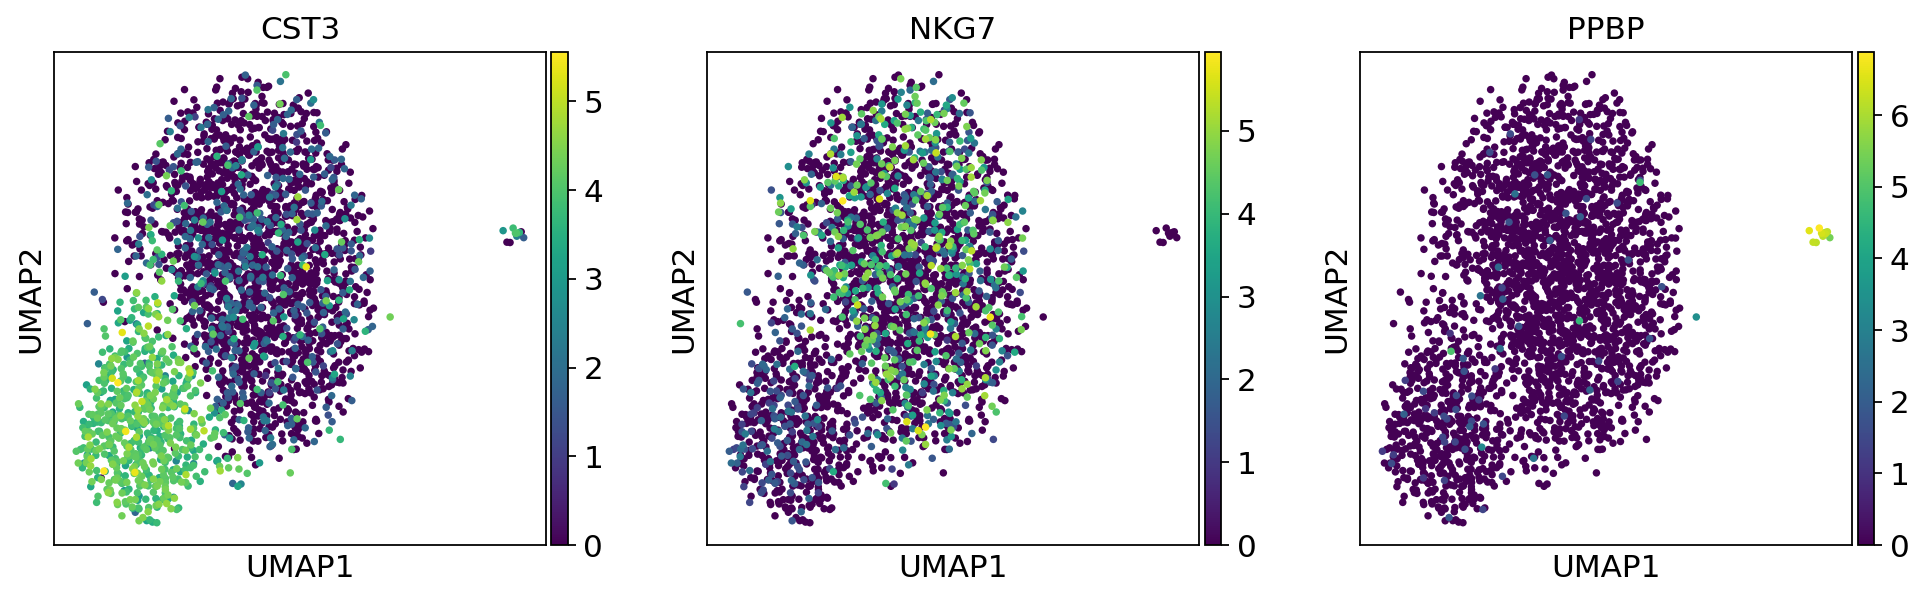

In [62]:
#computing the neighborhood graph on raw data, no PCs
sc.pp.neighbors(pcHVG_data, n_neighbors=10, n_pcs=0)
sc.tl.umap(pcHVG_data)
sc.pl.umap(pcHVG_data, color=['CST3', 'NKG7', 'PPBP'])


computing neighbors
    using 'X_pca' with n_pcs = 2
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


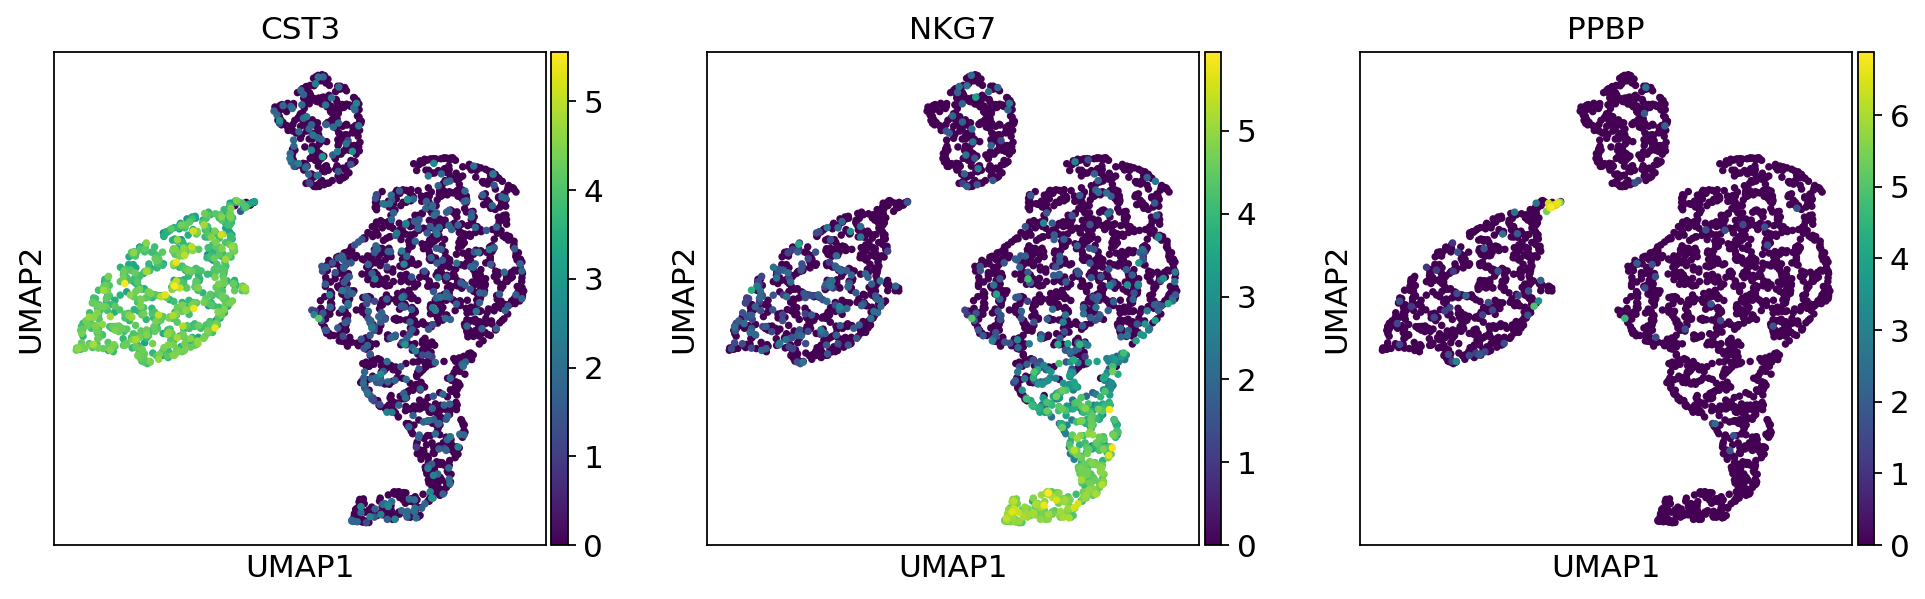

In [63]:

#how will the umap change if we use different numbers of PCs?

#computing the neighborhood graph, 2 PCs
sc.pp.neighbors(pcHVG_data, n_neighbors=10, n_pcs=2)
sc.tl.umap(pcHVG_data)
sc.pl.umap(pcHVG_data, color=['CST3', 'NKG7', 'PPBP'])


computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


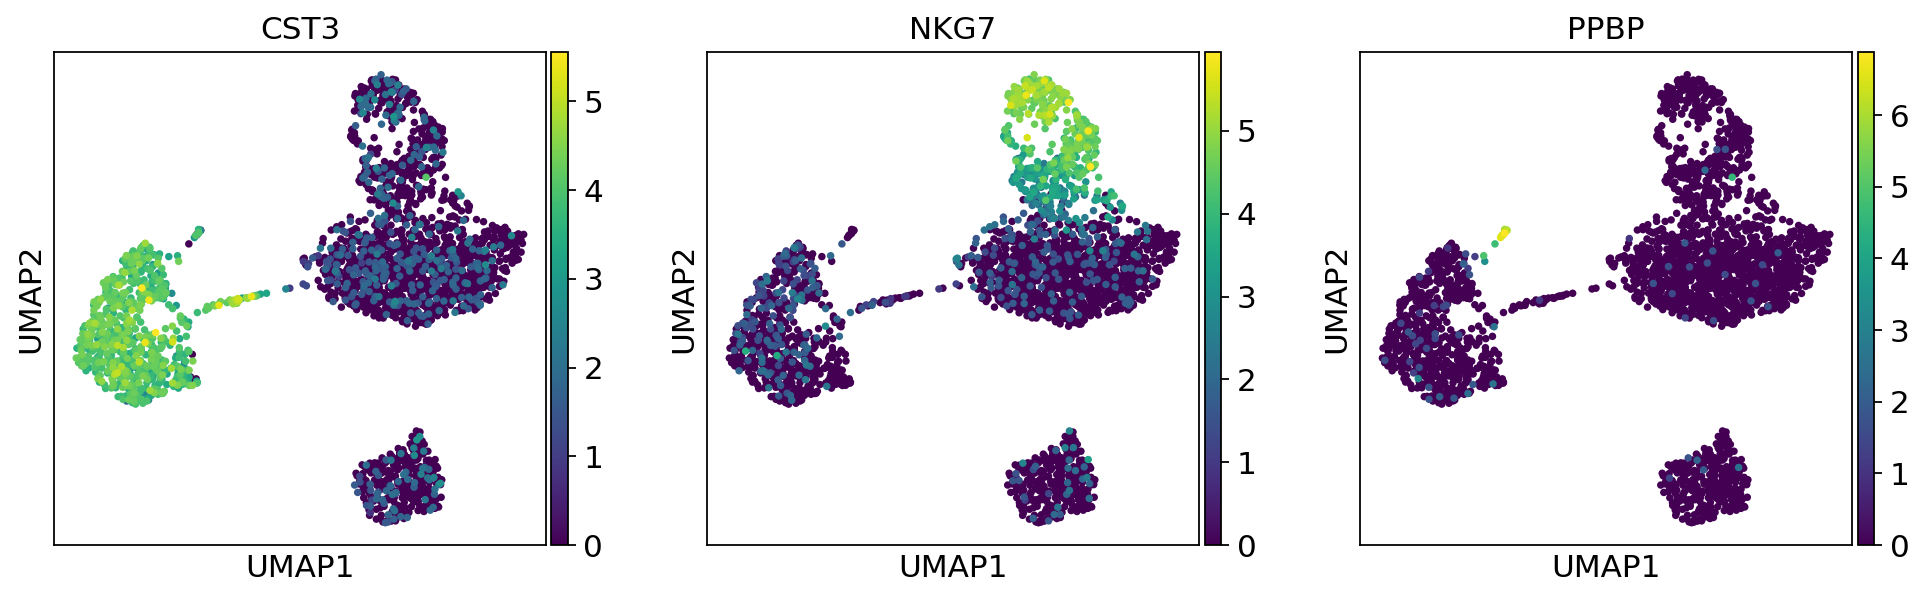

In [64]:
#computing the neighborhood graph, 10 PCs
sc.pp.neighbors(pcHVG_data, n_neighbors=10, n_pcs=10)
sc.tl.umap(pcHVG_data)
sc.pl.umap(pcHVG_data, color=['CST3', 'NKG7', 'PPBP'])


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


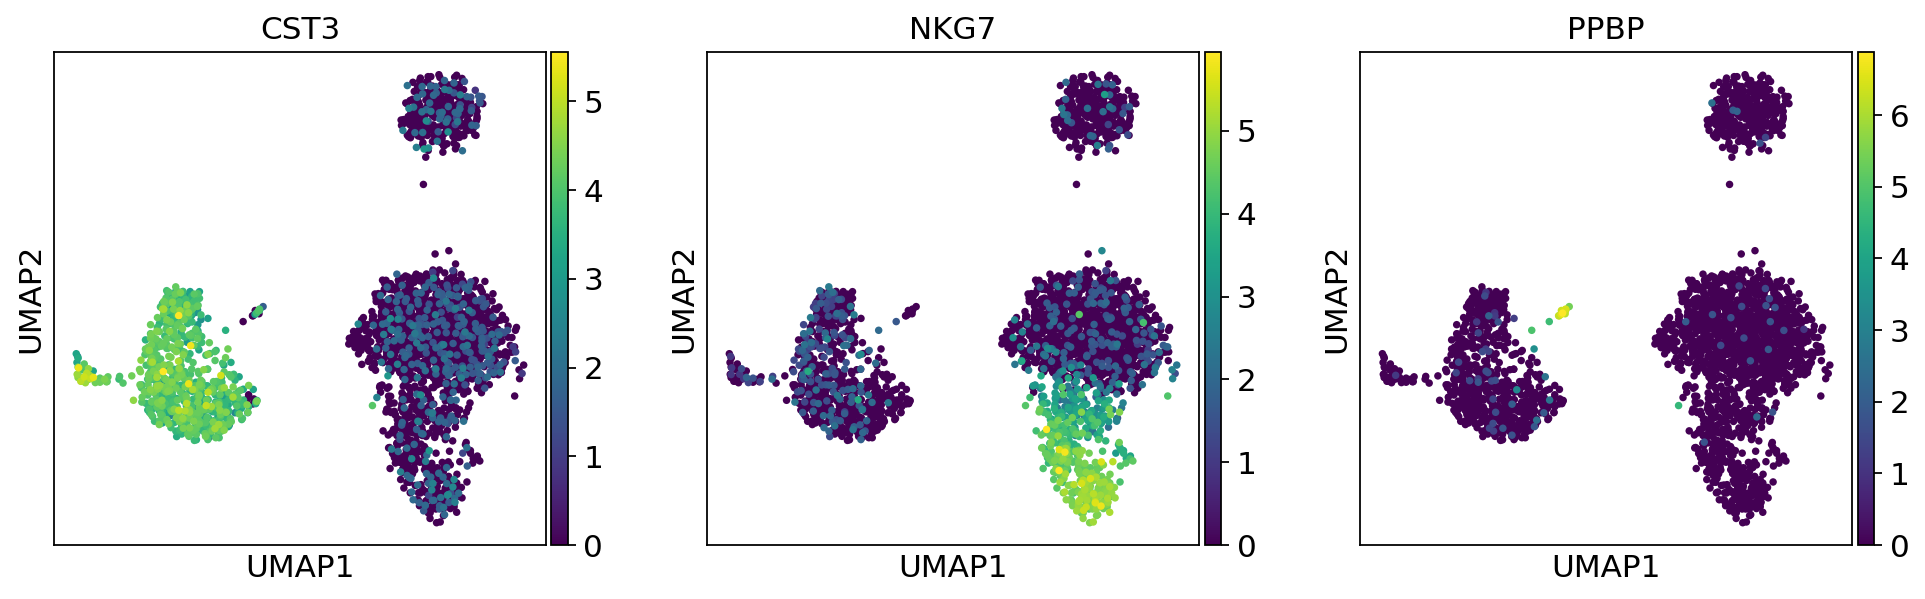

In [66]:
#computing the neighborhood graph, 50 PCs
sc.pp.neighbors(pcHVG_data, n_neighbors=10, n_pcs=50)
sc.tl.umap(pcHVG_data)
sc.pl.umap(pcHVG_data, color=['CST3', 'NKG7', 'PPBP'])


In [ ]:
#The choice of the number of PCs is a similar question to the choice of the number of highly variable genes to keep. 
# More PCs means more noise but also more biological signal.
# A simple heuristic for choosing the number of PCs generates an “Elbow plot”: a ranking of the PCs based on the percentage of variance they explain.

#To determine the elbow point, we assume that each of the PCs should explain much more variance than the remaining PCS. 
# So after the last PCs we choose, the percentage of variance explained should not drop much.
# *BUT We encourage users to repeat downstream analyses with different number of PCs.

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP


/usr/local/lib64/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


<IPython.core.display.Javascript object>

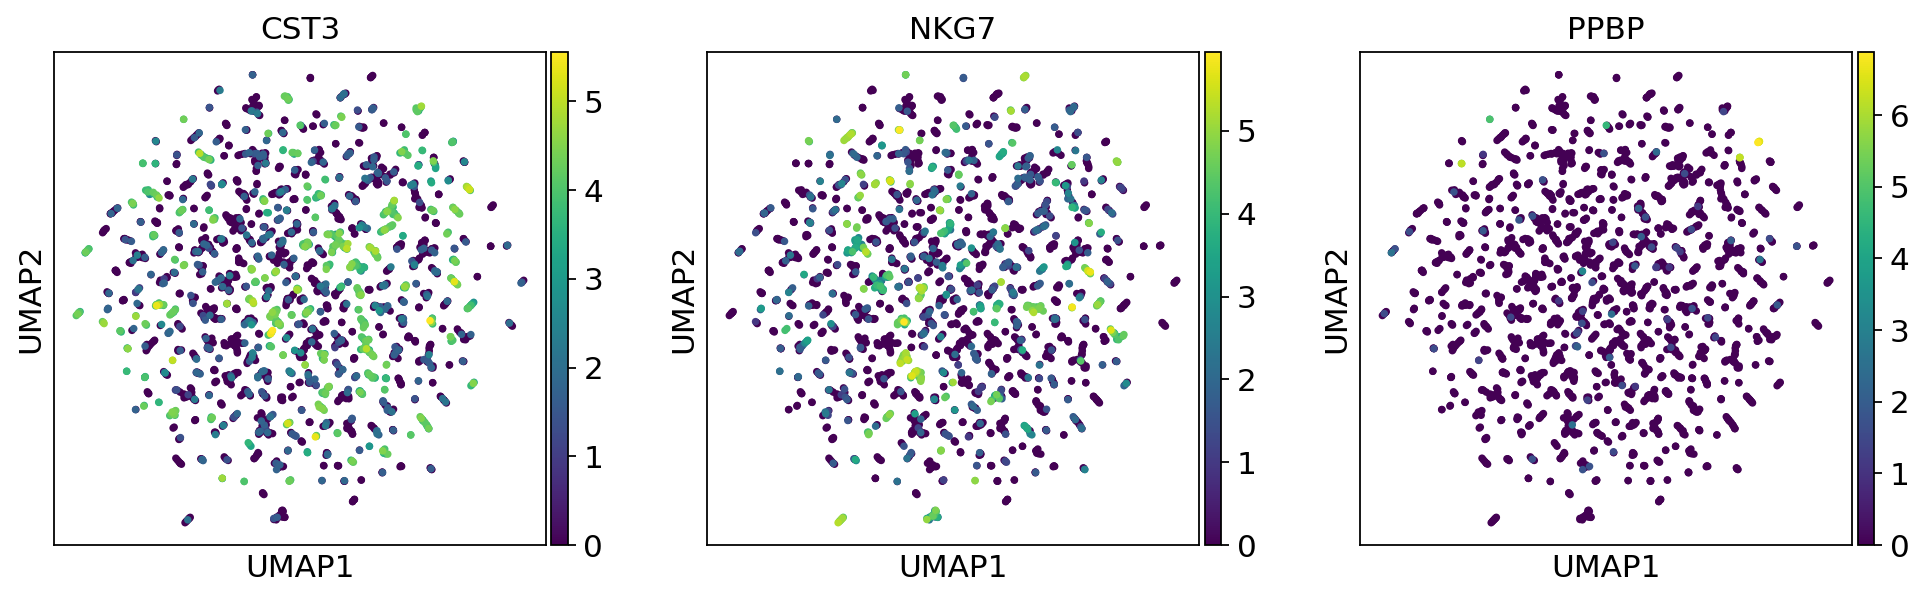

In [82]:
#what if we change the number of neighbors?

#2 neighbors
sc.pp.neighbors(pcHVG_data, n_neighbors=2, n_pcs=20)
sc.tl.umap(pcHVG_data)
sc.pl.umap(pcHVG_data, color=['CST3', 'NKG7', 'PPBP'])


computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


<IPython.core.display.Javascript object>

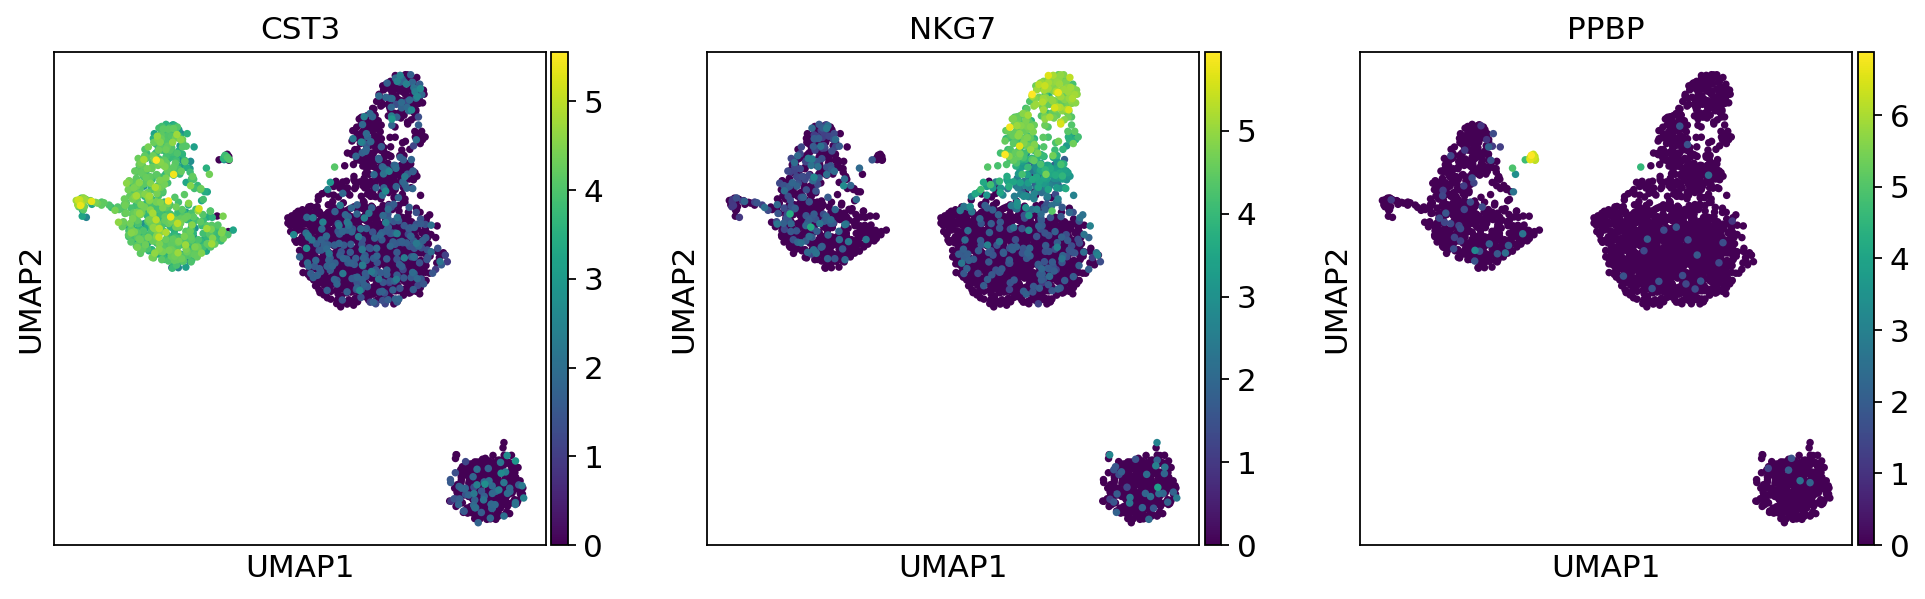

In [83]:
#30 neighbors
sc.pp.neighbors(pcHVG_data, n_neighbors=30, n_pcs=20)
sc.tl.umap(pcHVG_data)
sc.pl.umap(pcHVG_data, color=['CST3', 'NKG7', 'PPBP'])


computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


<IPython.core.display.Javascript object>

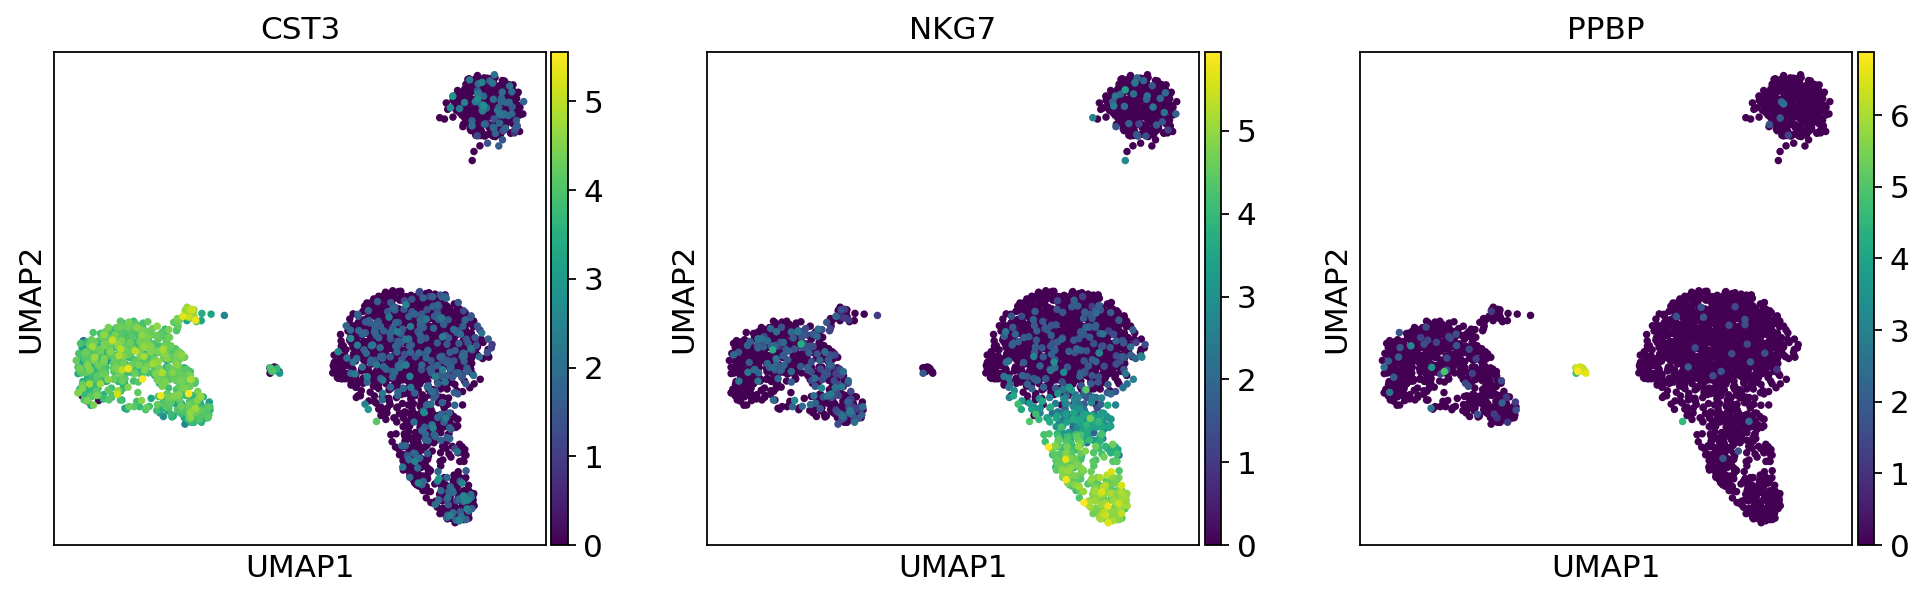

In [84]:

#100 neighbors
sc.pp.neighbors(pcHVG_data, n_neighbors=100, n_pcs=20)
sc.tl.umap(pcHVG_data)
sc.pl.umap(pcHVG_data, color=['CST3', 'NKG7', 'PPBP'])

